In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install Detectron2 Dependencies

In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 21 kB/s 
     |████████████████████████████████| 6.6 MB 32.7 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.5.0+cu101

In [ ]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2 MB 600 kB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=2336b44ccfe80556f892d0a47e5ccc3a5dbbf52fbcfe6b77704c1ee6f40366ac
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e48078756505c7777b75b29e
Successfully built fvcore


In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

# Import and Register Custom Detectron2 Data

In [ ]:
!curl -L "https://app.roboflow.com/ds/tuvr6lYAFo?key=1ZKjiU5nok" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0   1739      0 --:--:-- --:--:-- --:--:--  1742
100   248  100   248    0     0    324      0 --:--:-- --:--:-- --:--:--   324
Archive:  roboflow.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of roboflow.zip or
        roboflow.zip.zip, and cannot find roboflow.zip.ZIP, period.


In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train2", {}, "/content/gdrive/MyDrive/6th-sem-project-3/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val2", {}, "/content//MyDrive/6th-sem-project-3/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test2", {}, "/content//MyDrive/6th-sem-project-3/test/_annotations.coco.json", "/content/test")

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train1", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val1", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test1", {}, "/content/test/_annotations.coco.json", "/content/test")

In [ ]:
!ls /content/drive/MyDrive/6th-sem-project-3/train/images

images	labels


In [ ]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train1")
dataset_dicts = DatasetCatalog.get("my_dataset_train1")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

FileNotFoundError: ignored

# Train Custom Detectron2 Detector

In [ ]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 2000 #2000
cfg.SOLVER.MAX_ITER = 10000 #8000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500) #
cfg.SOLVER.GAMMA = 0.05


cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 22      #your number of classes

cfg.TEST.EVAL_PERIOD = 1500

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/07 15:24:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

FileNotFoundError: ignored

In [ ]:
!cp -r "/content/output" "/content/drive/MyDrive"

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

# Inference with Detectron2 Saved Weights



In [ ]:
%ls ./output/

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

Predictions

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])


# Inference with Detectron2 Saved Weights in Drive



In [ ]:
#!cp -r "/content/output" "/content/drive/MyDrive/Models"

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join("/content/drive/MyDrive/Models/coco_mask_rcnn_output/", "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

Predictions

WARNING [05/06 20:02:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/06 20:02:26 d2.data.datasets.coco]: Loaded 711 images in COCO format from /content/test/_annotations.coco.json


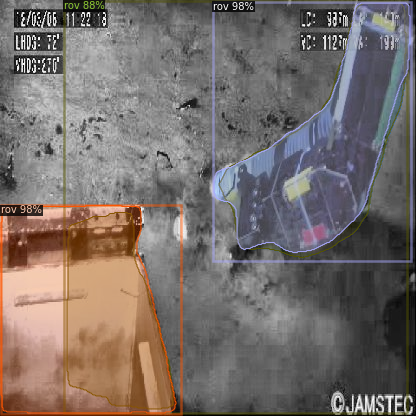

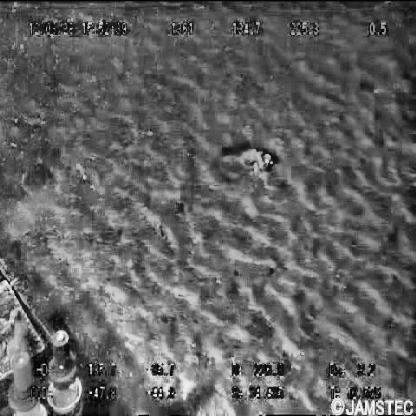

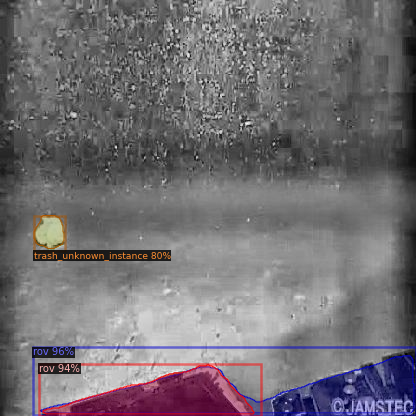

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("my_dataset_test")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])